In [1]:
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# function for preprocessing a text string
def preprocess_text(text):
    # Instantiate lemmatizer
    lemma = WordNetLemmatizer()
    # Expanded stop words
    stop = stopwords.words('english')
    # stop.extend(['im','ive','got', 'wa', 'ha'])
    # Remove punctuation and lower case words
    words_list = re.sub(r'[^a-zA-Z ]','',text.lower()).split()
    words_list = [lemma.lemmatize(i) for i in words_list]
    words_list = [i for i in words_list if i not in stop]
    return ' '.join(words_list)


### Reading in the data

In [3]:
exercise = pd.read_csv('./Data/cleaned_exercise.csv')
happy = pd.read_csv('./Data/cleaned_happy.csv')

In [4]:
exercise.head()

,Unnamed: 0,subreddit,author,domain,timecreated,Post
0,1,Exercise,empyreandreams,i.redd.it,2022-04-01 12:55:40,
1,2,Exercise,empyreandreams,i.redd.it,2022-03-18 14:41:31,
2,3,Exercise,empyreandreams,ncbi.nlm.nih.gov,2022-02-16 12:42:31,no time to lift designing time efficient train...
3,5,Exercise,empyreandreams,eurekalert.org,2022-02-15 14:24:01,scientists have found that switching from a li...
4,6,Exercise,empyreandreams,youtu.be,2022-02-15 14:20:06,shinrin yoku introducing the japanese practice...


In [5]:
happy.head()

,Unnamed: 0,subreddit,author,domain,timecreated,Post
0,0,happy,pottersheadforever,instagram.com,2019-03-31 23:13:45,happy april fools day
1,1,happy,gryffindorwannabe,i.redd.it,2019-03-31 22:36:38,me and my girlfriend went parasailing and it w...
2,2,happy,LunaRose108,i.redd.it,2019-03-31 21:40:21,i was in a really dark place for many years i ...
3,3,happy,c_zim,i.imgur.com,2019-03-31 20:53:06,my fianc e and our dog always nap together on ...
4,4,happy,brndnw4lf,self.happy,2019-03-31 20:44:35,six years ago i wanted to die i m now living m...


In [6]:
# remove the unnamed columns
exercise = exercise.drop('Unnamed: 0', axis=1)
happy = happy.drop('Unnamed: 0', axis=1)

In [7]:
exercise.head()

,subreddit,author,domain,timecreated,Post
0,Exercise,empyreandreams,i.redd.it,2022-04-01 12:55:40,
1,Exercise,empyreandreams,i.redd.it,2022-03-18 14:41:31,
2,Exercise,empyreandreams,ncbi.nlm.nih.gov,2022-02-16 12:42:31,no time to lift designing time efficient train...
3,Exercise,empyreandreams,eurekalert.org,2022-02-15 14:24:01,scientists have found that switching from a li...
4,Exercise,empyreandreams,youtu.be,2022-02-15 14:20:06,shinrin yoku introducing the japanese practice...


In [8]:
happy.head()

,subreddit,author,domain,timecreated,Post
0,happy,pottersheadforever,instagram.com,2019-03-31 23:13:45,happy april fools day
1,happy,gryffindorwannabe,i.redd.it,2019-03-31 22:36:38,me and my girlfriend went parasailing and it w...
2,happy,LunaRose108,i.redd.it,2019-03-31 21:40:21,i was in a really dark place for many years i ...
3,happy,c_zim,i.imgur.com,2019-03-31 20:53:06,my fianc e and our dog always nap together on ...
4,happy,brndnw4lf,self.happy,2019-03-31 20:44:35,six years ago i wanted to die i m now living m...


In [9]:
# checking for null values and dtypes
exercise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    9659 non-null   object
 1   author       9659 non-null   object
 2   domain       9659 non-null   object
 3   timecreated  9659 non-null   object
 4   Post         9659 non-null   object
dtypes: object(5)
memory usage: 377.4+ KB


In [10]:
happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14621 entries, 0 to 14620
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    14621 non-null  object
 1   author       14621 non-null  object
 2   domain       14620 non-null  object
 3   timecreated  14621 non-null  object
 4   Post         14621 non-null  object
dtypes: object(5)
memory usage: 571.3+ KB


In [11]:
exercise.isnull().sum()

subreddit      0
author         0
domain         0
timecreated    0
Post           0
dtype: int64

In [12]:
happy.isnull().sum()

subreddit      0
author         0
domain         1
timecreated    0
Post           0
dtype: int64

* domain has 1 null value

### EDA

In [13]:
# create a combined dataframe for neutral texts in order to find the common words in both
combined_df = pd.concat([exercise, happy])

# shuffling the dataframe
combined_df = combined_df.sample(frac=1, ignore_index=True, random_state=42)

In [14]:
combined_df

,subreddit,author,domain,timecreated,Post
0,happy,Vardalia,self.happy,2021-03-13 11:10:58,i am happy today that my daughter is beating t...
1,Exercise,Edwoodz3,self.Exercise,2019-10-12 08:35:47,looking for a solid stretching routine i ve go...
2,happy,WeswePengu,self.happy,2019-05-27 03:19:07,i am no longer living paycheck to paycheck it ...
3,happy,modernbutterfly,self.happy,2019-01-23 08:42:33,i m happy yet i m not satisfied is that bad a...
4,Exercise,talksay,self.Exercise,2019-11-20 07:05:13,i have a question my butt is the biggest thing...
...,...,...,...,...,...
24275,happy,tstofan31,self.happy,2021-06-19 15:48:48,juneteenth makes me happy especially now that ...
24276,Exercise,j483,self.Exercise,2020-03-11 12:34:36,do the work enjoy the benefit staying flexibl...
24277,Exercise,fashion_guide,fashionguide.co.in,2021-08-22 03:58:56,on international yoga day here are of the bes...
24278,happy,krzykttn,reddit.com,2021-02-18 21:40:42,i ve had a really tough few months i was able ...


In [15]:
# these ones don't have self text

X = combined_df['Post']
y = combined_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

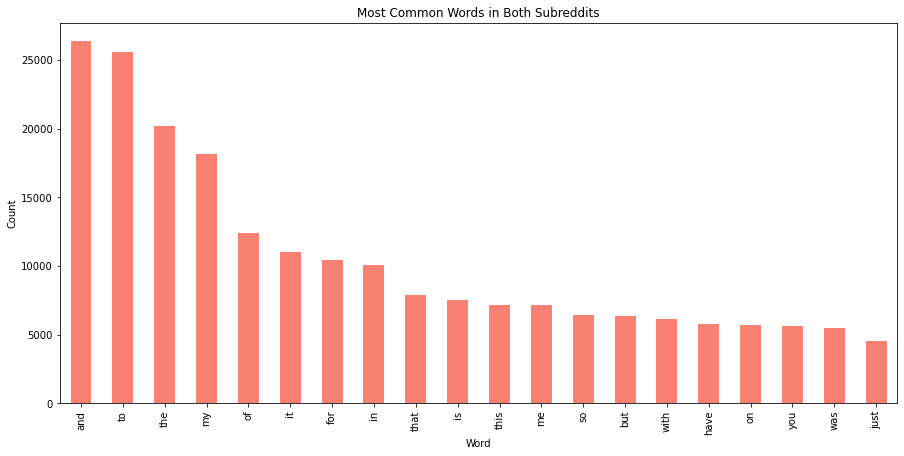

In [16]:
# plotting the most common words in both exercise and happy 
cvec = CountVectorizer()
x = cvec.fit_transform(X_train)
cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(15,7))
cvec_df.sum().sort_values(ascending = False).head(20).plot(kind = 'bar', color='salmon')
plt.title('Most Common Words in Both Subreddits')
plt.xlabel('Word')
plt.ylabel('Count');

The most common words are the words that don't have much meaning and can be removed as stopwords

In [17]:
# applying the preprocess function to remove stopwords
combined_df['Post'] = combined_df['Post'].apply(lambda x: preprocess_text(x))

In [18]:
# creating the plot again
# these ones don't have self text

X = combined_df['Post']
y = combined_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

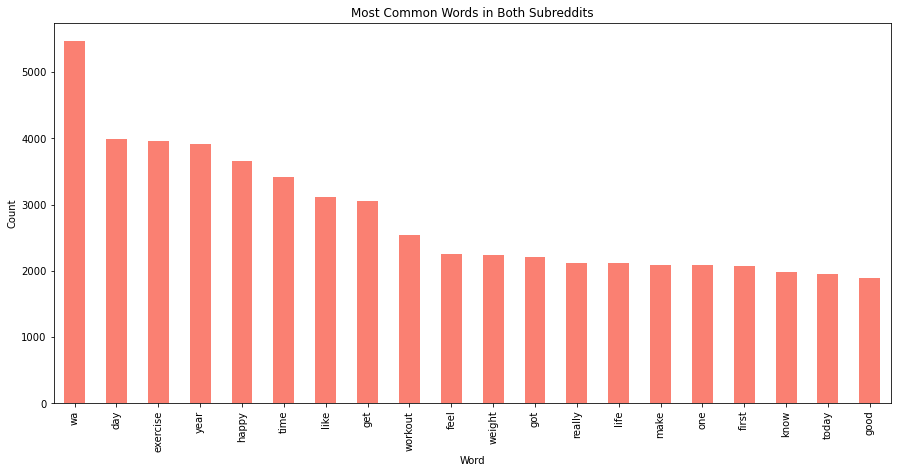

In [19]:
# plotting the most common words in both exercise and happy 
cvec = CountVectorizer()
x = cvec.fit_transform(X_train)
cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(15,7))
cvec_df.sum().sort_values(ascending = False).head(20).plot(kind = 'bar', color='salmon')
plt.title('Most Common Words in Both Subreddits')
plt.xlabel('Word')
plt.ylabel('Count');

I can remove the words - wa, today, day, get, got, one

In [20]:
# # separating the subreddits to get the most common words for each subreddit
df1 = combined_df[combined_df['subreddit'] == 'Exercise']
df2 = combined_df[combined_df['subreddit'] == 'happy']

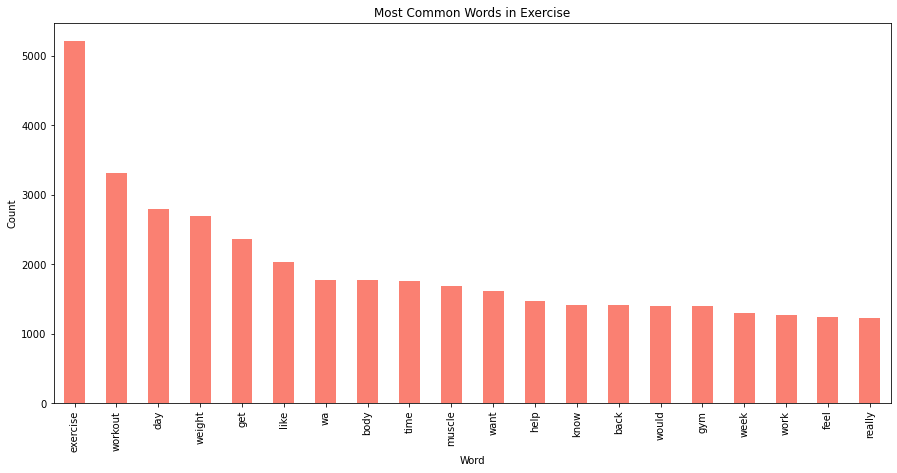

In [21]:
cvec = CountVectorizer()
x = cvec.fit_transform(df1['Post'])
cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(15,7))
cvec_df.sum().sort_values(ascending = False).head(20).plot(kind = 'bar', color='salmon')
plt.title('Most Common Words in Exercise')
plt.xlabel('Word')
plt.ylabel('Count');

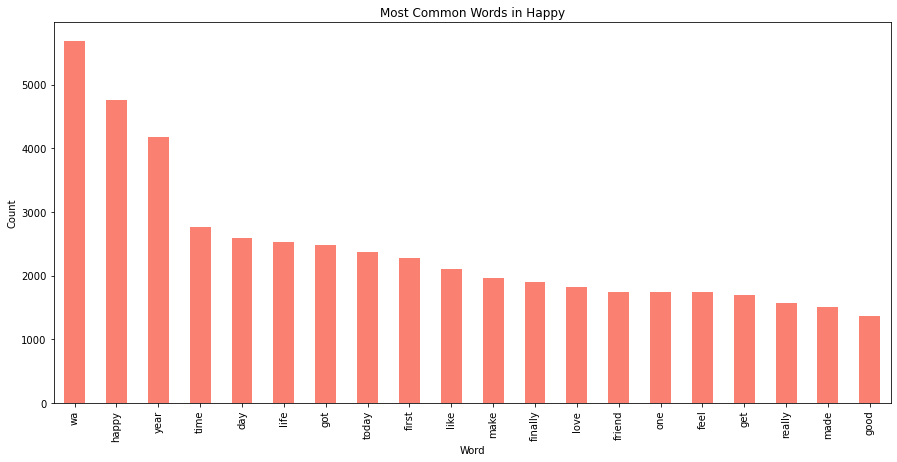

In [22]:
# finding the most common words in the happy subreddit
cvec = CountVectorizer()
x = cvec.fit_transform(df2['Post'])
cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(15,7))
cvec_df.sum().sort_values(ascending = False).head(20).plot(kind = 'bar', color='salmon')
plt.title('Most Common Words in Happy')
plt.xlabel('Word')
plt.ylabel('Count');

### Adding more stopwords

In [23]:
# change the initial function to add stopwords
# function for preprocessing a text string
def preprocess_text(text, new_words=[]):
    # Instantiate lemmatizer
    lemma = WordNetLemmatizer()
    # Expanded stop words
    stop = stopwords.words('english')
    stop.extend(new_words)
    # Remove punctuation and lower case words
    words_list = re.sub(r'[^a-zA-Z ]','',text.lower()).split()
    words_list = [lemma.lemmatize(i) for i in words_list]
    words_list = [i for i in words_list if i not in stop]
    return ' '.join(words_list)


In [24]:
# applying the preprocess function to remove stopwords
combined_df['Post'] = combined_df['Post'].apply(lambda x: preprocess_text(x, new_words=['wa', 'ha', 'day', 'today', 'get', 'got', 'one']))

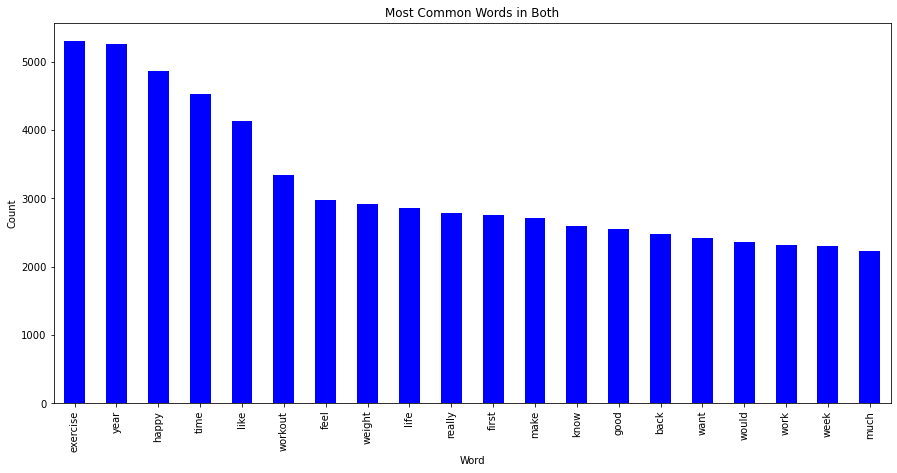

In [25]:
cvec = CountVectorizer()
x = cvec.fit_transform(combined_df['Post'])
cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(15,7))
cvec_df.sum().sort_values(ascending = False).head(20).plot(kind = 'bar', color='blue')
plt.title('Most Common Words in Both')
plt.xlabel('Word')
plt.ylabel('Count');

In [26]:
# # separating the subreddits to get the most common words for each subreddit
df1 = combined_df[combined_df['subreddit'] == 'Exercise']
df2 = combined_df[combined_df['subreddit'] == 'happy']

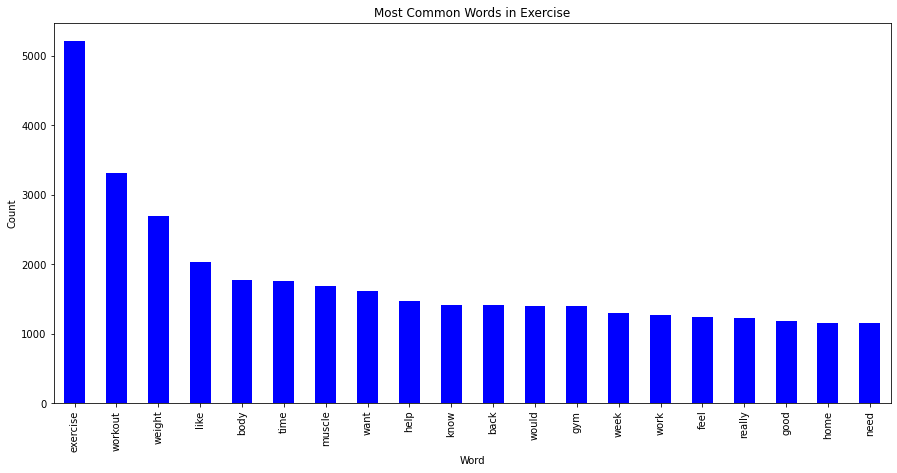

In [27]:
# finding the most common words in Exercise subreddit
cvec = CountVectorizer()
x = cvec.fit_transform(df1['Post'])
cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(15,7))
cvec_df.sum().sort_values(ascending = False).head(20).plot(kind = 'bar', color='blue')
plt.title('Most Common Words in Exercise')
plt.xlabel('Word')
plt.ylabel('Count');

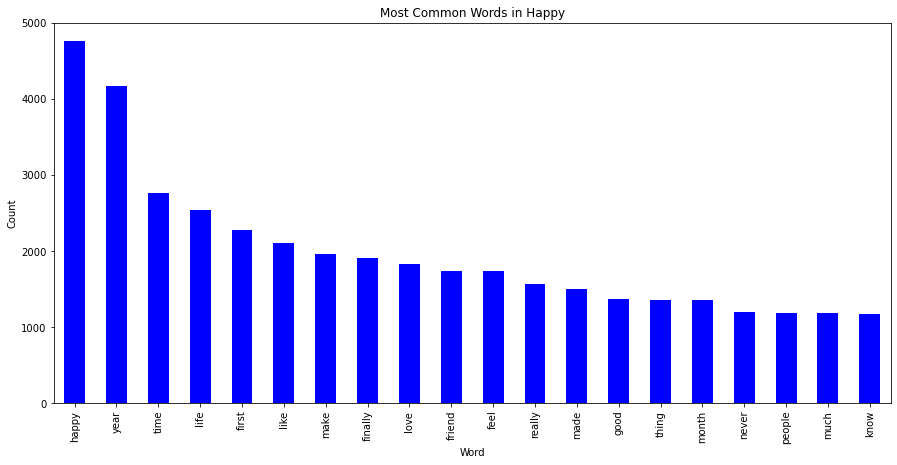

In [28]:
# finding the most common words in happy subreddit
cvec = CountVectorizer()
x = cvec.fit_transform(df2['Post'])
cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(15,7))
cvec_df.sum().sort_values(ascending = False).head(20).plot(kind = 'bar', color='blue')
plt.title('Most Common Words in Happy')
plt.xlabel('Word')
plt.ylabel('Count');

#### Word Count per Subreddit

In [29]:
# splitting the posts and finding out the length to get the word count
combined_df['word_count'] = combined_df['Post'].apply(lambda x : len(x.split()))

In [30]:
combined_df

,subreddit,author,domain,timecreated,Post,word_count
0,happy,Vardalia,self.happy,2021-03-13 11:10:58,happy daughter beating crap anxiety guy show d...,46
1,Exercise,Edwoodz3,self.Exercise,2019-10-12 08:35:47,looking solid stretching routine horrendous fl...,30
2,happy,WeswePengu,self.happy,2019-05-27 03:19:07,longer living paycheck paycheck wonderful free...,107
3,happy,modernbutterfly,self.happy,2019-01-23 08:42:33,happy yet satisfied bad advice,5
4,Exercise,talksay,self.Exercise,2019-11-20 07:05:13,question butt biggest thing make smaller diet ...,8
...,...,...,...,...,...,...
24275,happy,tstofan31,self.happy,2021-06-19 15:48:48,juneteenth make happy especially federal holid...,51
24276,Exercise,j483,self.Exercise,2020-03-11 12:34:36,work enjoy benefit staying flexible http imgur...,10
24277,Exercise,fashion_guide,fashionguide.co.in,2021-08-22 03:58:56,international yoga best yoga pose know,6
24278,happy,krzykttn,reddit.com,2021-02-18 21:40:42,really tough month able sculpt snow queen due ...,23


In [31]:
combined_df.groupby('subreddit').sum()['word_count']

subreddit
Exercise    257257
happy       290137
Name: word_count, dtype: int64

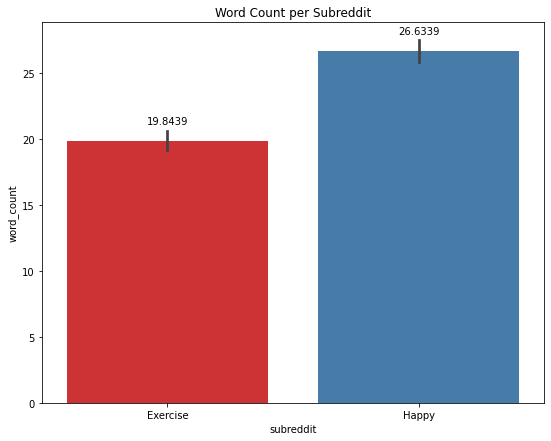

In [32]:
fig, ax = plt.subplots(figsize=(9,7))
ax = sns.barplot(data=combined_df, x='subreddit', y='word_count', palette='Set1')
ax.bar_label(ax.containers[0], padding=15)
ax.set_xticklabels(['Exercise', 'Happy'])
ax.set_title('Word Count per Subreddit');

# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

### Sentiment Analysis

In [33]:
# The Sentiment Analyzer takes a list of strings
exercise_corpus = list(df1['Post'])
happy_corpus = list(df2['Post'])
combined_corpus = list(combined_df['Post'])

In [34]:
exercise_corpus[:3]

['looking solid stretching routine horrendous flexibility always gotten lot worse since tore bicep femoris tendon year ago hamstring terrible believe hip flexor incredibly tight anyway strong stretching routine every night',
 'question butt biggest thing make smaller diet routine',
 'exercise every month gained weight discouraged worked hour half every month gained weight weight training cardio enough weight gain much muscle even want go anymore know look scale feel look different either female weigh want weight']

In [35]:
happy_corpus[:3]

['happy daughter beating crap anxiety guy show daughter support yr old baby recently medicated anxiety follow first thing told proud progress voice character dad child show care people think proud baby episode talking play pink dog big eye table also yellow labrador chair http youtu ludqmwzcug',
 'longer living paycheck paycheck wonderful freeing expierence first job year old make much made enough live roommate problem living paycheck paycheck enough money pay pay bill buy grocery nothing healthy though nothing else situation like year finally year hit milestone little something interesting musician play piano lot video game music time income music money receiving could barely afford rent cut corner could sure happened music must gotten popular making much actually establish saving year time went barely supporting actually thinking future house actually might able buy house engaged well amazing woman ever completely support music love sorry story structured well important thing finally

In [36]:
combined_corpus[:3]

['happy daughter beating crap anxiety guy show daughter support yr old baby recently medicated anxiety follow first thing told proud progress voice character dad child show care people think proud baby episode talking play pink dog big eye table also yellow labrador chair http youtu ludqmwzcug',
 'looking solid stretching routine horrendous flexibility always gotten lot worse since tore bicep femoris tendon year ago hamstring terrible believe hip flexor incredibly tight anyway strong stretching routine every night',
 'longer living paycheck paycheck wonderful freeing expierence first job year old make much made enough live roommate problem living paycheck paycheck enough money pay pay bill buy grocery nothing healthy though nothing else situation like year finally year hit milestone little something interesting musician play piano lot video game music time income music money receiving could barely afford rent cut corner could sure happened music must gotten popular making much actually

#### Checking the Sentiment score for the first post from each subreddit and combined

In [37]:
#instantiate SIA
sia = SentimentIntensityAnalyzer()

#Get polarity scores for the first tweet
sia.polarity_scores(exercise_corpus[0])

{'neg': 0.241, 'neu': 0.577, 'pos': 0.182, 'compound': -0.5325}

* positive sentiment : (compound score >= 0.05)
* neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
* negative sentiment : (compound score <= -0.05)

In [38]:
#instantiate SIA
sia = SentimentIntensityAnalyzer()

#Get polarity scores for the first tweet
sia.polarity_scores(happy_corpus[0])

{'neg': 0.138, 'neu': 0.538, 'pos': 0.323, 'compound': 0.9186}

In [39]:
#instantiate SIA
sia = SentimentIntensityAnalyzer()

#Get polarity scores for the first tweet
sia.polarity_scores(combined_corpus[0])

{'neg': 0.138, 'neu': 0.538, 'pos': 0.323, 'compound': 0.9186}

#### Create a dataframe for the sentiment polarity scores and the posts

In [40]:
#create dataframe that contains text and the polarity scores for each post for exercise subreddit

sentiment = []    

for post in exercise_corpus:
    scores = sia.polarity_scores(post)
    scores['post'] = post
    sentiment.append(scores)

exercise_df = pd.DataFrame(sentiment)
exercise_df.head()

,neg,neu,pos,compound,post
0,0.241,0.577,0.182,-0.5325,looking solid stretching routine horrendous fl...
1,0.000,1.000,0.000,0.0000,question butt biggest thing make smaller diet ...
2,0.062,0.683,0.255,0.7579,exercise every month gained weight discouraged...
3,0.058,0.732,0.209,0.7528,hamstring stretch deadlifting deadlifting comi...
4,0.225,0.775,0.000,-0.4404,yoga complete beginner part part introduction ...


In [41]:
#create dataframe that contains text and the polarity scores for each post for happy subreddit

sentiment = []    

for post in happy_corpus:
    scores = sia.polarity_scores(post)
    scores['post'] = post
    sentiment.append(scores)

happy_df = pd.DataFrame(sentiment)
happy_df.head()

,neg,neu,pos,compound,post
0,0.138,0.538,0.323,0.9186,happy daughter beating crap anxiety guy show d...
1,0.091,0.589,0.320,0.9869,longer living paycheck paycheck wonderful free...
2,0.292,0.167,0.542,0.4588,happy yet satisfied bad advice
3,0.168,0.489,0.342,0.7506,content city beauty multi action sculpting cre...
4,0.000,0.000,1.000,0.4588,sweet


In [42]:
#create dataframe that contains text and the polarity scores for each post for combined subreddits

sentiment = []    

for post in combined_corpus:
    scores = sia.polarity_scores(post)
    scores['post'] = post
    sentiment.append(scores)

df = pd.DataFrame(sentiment)
df.head()

,neg,neu,pos,compound,post
0,0.138,0.538,0.323,0.9186,happy daughter beating crap anxiety guy show d...
1,0.241,0.577,0.182,-0.5325,looking solid stretching routine horrendous fl...
2,0.091,0.589,0.320,0.9869,longer living paycheck paycheck wonderful free...
3,0.292,0.167,0.542,0.4588,happy yet satisfied bad advice
4,0.000,1.000,0.000,0.0000,question butt biggest thing make smaller diet ...


#### Adding a target column to the happy and exercise dataframes where 1 = happy and 0 = exercise

In [43]:
exercise_df['target'] = 0
happy_df['target'] = 1

In [44]:
exercise_df.head()

,neg,neu,pos,compound,post,target
0,0.241,0.577,0.182,-0.5325,looking solid stretching routine horrendous fl...,0
1,0.000,1.000,0.000,0.0000,question butt biggest thing make smaller diet ...,0
2,0.062,0.683,0.255,0.7579,exercise every month gained weight discouraged...,0
3,0.058,0.732,0.209,0.7528,hamstring stretch deadlifting deadlifting comi...,0
4,0.225,0.775,0.000,-0.4404,yoga complete beginner part part introduction ...,0


In [45]:
happy_df.head()

,neg,neu,pos,compound,post,target
0,0.138,0.538,0.323,0.9186,happy daughter beating crap anxiety guy show d...,1
1,0.091,0.589,0.320,0.9869,longer living paycheck paycheck wonderful free...,1
2,0.292,0.167,0.542,0.4588,happy yet satisfied bad advice,1
3,0.168,0.489,0.342,0.7506,content city beauty multi action sculpting cre...,1
4,0.000,0.000,1.000,0.4588,sweet,1


#### Checking the negative and positive polarities

In [46]:
exercise_df.sort_values(by = 'pos', ascending = False).head(10)

,neg,neu,pos,compound,post,target
2807,0.0,0.0,1.0,0.5423,fitness motivation,0
1479,0.0,0.0,1.0,0.4215,true,0
5329,0.0,0.0,1.0,0.3612,fit,0
4486,0.0,0.0,1.0,0.5859,wow,0
1365,0.0,0.0,1.0,0.3400,f fitness challenge,0
8363,0.0,0.0,1.0,0.5574,restoring flexibility,0
3467,0.0,0.0,1.0,0.4019,help,0
6627,0.0,0.0,1.0,0.4019,help,0
8023,0.0,0.0,1.0,0.4588,help pls,0
3755,0.0,0.0,1.0,0.4404,improve,0


In [47]:
exercise_df.sort_values(by = 'neg', ascending = False).head(10)

,neg,neu,pos,compound,post,target
5538,1.000,0.000,0.0,-0.4019,damn,0
9637,1.000,0.000,0.0,-0.6908,kill,0
3596,1.000,0.000,0.0,-0.4767,wrong,0
9183,1.000,0.000,0.0,-0.2500,stuck,0
4629,1.000,0.000,0.0,-0.4404,weak,0
1775,1.000,0.000,0.0,-0.5106,panic,0
6792,0.865,0.135,0.0,-0.7506,bad tired exercise,0
7873,0.835,0.165,0.0,-0.9445,banned im back fucking cunt fuck hell,0
1837,0.811,0.189,0.0,-0.6486,headphone dead,0
6920,0.778,0.222,0.0,-0.5423,fuck called,0


In [48]:
happy_df.sort_values(by = 'pos', ascending = False).head(10)

,neg,neu,pos,compound,post,target
5766,0.0,0.0,1.0,0.5719,happy,1
4852,0.0,0.0,1.0,0.9001,beautiful worthy love,1
7987,0.0,0.0,1.0,0.5719,happy,1
6288,0.0,0.0,1.0,0.3612,like,1
9947,0.0,0.0,1.0,0.4939,friend,1
1618,0.0,0.0,1.0,0.5106,free,1
4611,0.0,0.0,1.0,0.4588,glad,1
1609,0.0,0.0,1.0,0.5719,happy,1
3029,0.0,0.0,1.0,0.4767,proud,1
11573,0.0,0.0,1.0,0.5859,feeling appreciated,1


In [49]:
happy_df.sort_values(by = 'neg', ascending = False).head(10)

,neg,neu,pos,compound,post,target
4650,1.0,0.0,0.0,-0.0516,leave,1
8189,1.0,0.0,0.0,-0.7430,battle depression,1
9589,1.0,0.0,0.0,-0.1531,miss,1
13712,1.0,0.0,0.0,-0.1027,idk,1
8553,1.0,0.0,0.0,-0.3400,stressed,1
3846,1.0,0.0,0.0,-0.4767,cry,1
9356,1.0,0.0,0.0,-0.7430,fight depression,1
4765,1.0,0.0,0.0,-0.4404,scared,1
12846,1.0,0.0,0.0,-0.4767,cry,1
4783,1.0,0.0,0.0,-0.4767,sad,1


#### Visualizing the sentiments

In [50]:
df = pd.concat([exercise_df, happy_df], ignore_index=True)
df = df.sample(frac=1, ignore_index=True, random_state=42)
df.head()

,neg,neu,pos,compound,post,target
0,0.000,0.737,0.263,0.6908,danish concept lifestyle hygge examined well r...,1
1,0.000,0.919,0.081,0.4404,good final music song end treadmill run basica...,0
2,0.000,0.449,0.551,0.9930,making emotional support fragrance capture rig...,1
3,0.000,0.791,0.209,0.5719,stay awake movie night last night husband mth ...,1
4,0.093,0.727,0.180,0.6486,australian pull step benefit alternative diffe...,0


In [51]:
df[df['compound'] < 0]

,neg,neu,pos,compound,post,target
5,0.163,0.790,0.047,-0.6948,boxing cold hello train olympic boxing often w...,0
6,0.277,0.723,0.000,-0.3182,body transformation weight loss journey weigh ...,0
16,0.178,0.822,0.000,-0.3818,running short ride running short keep riding e...,0
23,0.243,0.539,0.218,-0.1885,almost died february th overdosed wanted die s...,1
30,0.266,0.504,0.231,-0.1935,old sunflower depressed mess little thing keep...,1
...,...,...,...,...,...,...
24257,0.206,0.689,0.104,-0.9661,year exercising still painful started walking ...,0
24262,0.201,0.638,0.160,-0.8996,something wrong keep going let start saying aw...,0
24267,0.195,0.651,0.153,-0.2263,new bichon abusive background living month fir...,1
24268,0.270,0.517,0.213,-0.2500,forester west coast boat dropped onto island y...,1


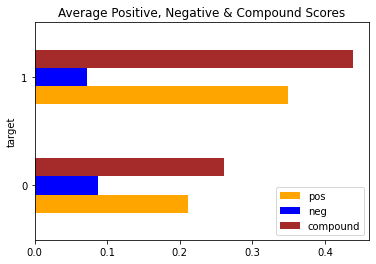

In [52]:
df.groupby('target').mean()[['pos', 'neg', 'compound']].plot(kind='barh', color=['orange', 'blue', 'brown'])
plt.title('Average Positive, Negative & Compound Scores');

Overall the posts are positive since the average compound scores are greater than 0.05

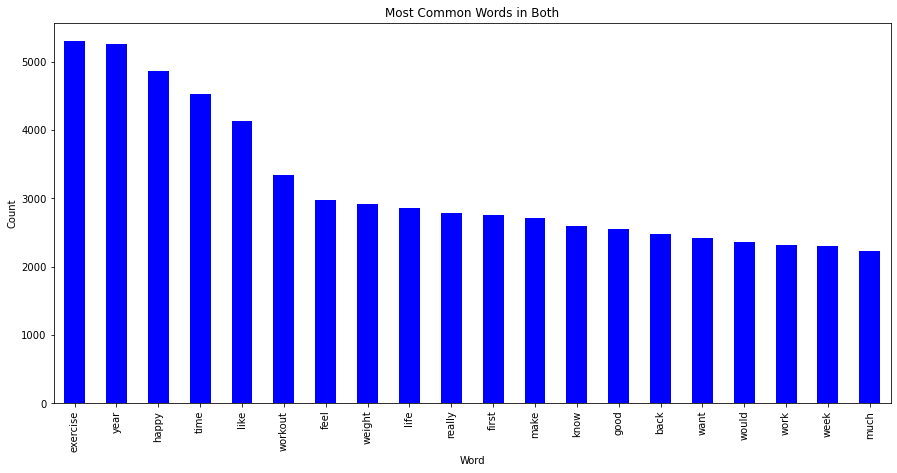

In [53]:
cvec = CountVectorizer(ngram_range=(1,1))
x = cvec.fit_transform(combined_df['Post'])
cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(15,7))
cvec_df.sum().sort_values(ascending = False).head(20).plot(kind = 'bar', color='blue')
plt.title('Most Common Words in Both')
plt.xlabel('Word')
plt.ylabel('Count');

In [54]:
cvec_df

,aa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaand,aaaah,aaaany,...,zwift,zwpcwv,zx,zxmzykz,zxxjw,zxxosmq,zyeta,zygapophyseal,zygapophysial,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
cvec = CountVectorizer(ngram_range=(3,3))
x = cvec.fit_transform(combined_corpus)
cvec_df = pd.DataFrame(x.todense(), 
                          columns=cvec.get_feature_names_out())



# plt.figure(figsize=(15,7))
# cvec_df.sum().sort_values(ascending = False).head(20).plot(kind = 'bar', color='blue')
# plt.title('Most Common Words in Both')
# plt.xlabel('Word')
# plt.ylabel('Count');

In [56]:
# combined_corpus

In [57]:
vec = CountVectorizer(ngram_range=(2,2), vocabulary=cvec_df.columns).fit_transform(combined_corpus)
sum_words = vec.sum(axis=0) 
# words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
# words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#     # return words_freq[:n]

In [58]:
np.max(sum_words)

0

In [60]:
# vec.to

In [62]:
df.columns = ['neg', 'neu', 'pos', 'compound', 'Post', 'Class']

In [63]:
df

,neg,neu,pos,compound,Post,Class
0,0.000,0.737,0.263,0.6908,danish concept lifestyle hygge examined well r...,1
1,0.000,0.919,0.081,0.4404,good final music song end treadmill run basica...,0
2,0.000,0.449,0.551,0.9930,making emotional support fragrance capture rig...,1
3,0.000,0.791,0.209,0.5719,stay awake movie night last night husband mth ...,1
4,0.093,0.727,0.180,0.6486,australian pull step benefit alternative diffe...,0
...,...,...,...,...,...,...
24275,0.000,0.448,0.552,0.5719,celebrated sobriety climbing mountain,1
24276,0.056,0.779,0.164,0.5478,idea long visible difference appearance week a...,0
24277,0.000,1.000,0.000,0.0000,ab per week full body work see lot recommendat...,0
24278,0.423,0.577,0.000,-0.8595,year ago hospitalized trying kill right snuggl...,1


In [65]:
df['Class'].replace({1: 'Exercise', 0: 'Happy'}, inplace=True)

In [66]:
df

,neg,neu,pos,compound,Post,Class
0,0.000,0.737,0.263,0.6908,danish concept lifestyle hygge examined well r...,Exercise
1,0.000,0.919,0.081,0.4404,good final music song end treadmill run basica...,Happy
2,0.000,0.449,0.551,0.9930,making emotional support fragrance capture rig...,Exercise
3,0.000,0.791,0.209,0.5719,stay awake movie night last night husband mth ...,Exercise
4,0.093,0.727,0.180,0.6486,australian pull step benefit alternative diffe...,Happy
...,...,...,...,...,...,...
24275,0.000,0.448,0.552,0.5719,celebrated sobriety climbing mountain,Exercise
24276,0.056,0.779,0.164,0.5478,idea long visible difference appearance week a...,Happy
24277,0.000,1.000,0.000,0.0000,ab per week full body work see lot recommendat...,Happy
24278,0.423,0.577,0.000,-0.8595,year ago hospitalized trying kill right snuggl...,Exercise


In [67]:
df.to_csv('neutral_senti.csv', index=False)